In [1]:
using Revise

In [1]:
using BeamPropagation, 
    Distributions, 
    UnitsToValue,
    StatsBase, 
    StaticArrays, 
    Plots,
    StructArrays,
    MutableNamedTuples,
    PhysicalConstants.CODATA2018,
    LinearAlgebra

In [150]:
# Define physical constants
const kB = BoltzmannConstant.val
const T = @with_unit 200 "μK"

# Define molecule parameters for CaOH
const m = @with_unit 57 "u"
const v_recoil = @with_unit 1.1 "cm/s"
;

In [151]:
Base.@kwdef struct AsymmetricGaussianTrap
    λ::Float64
    w0x::Float64
    w0y::Float64
    U_max::Float64
    m::Float64    
    zRx::Float64 = π * w0x^2 / λ
    zRy::Float64 = π * w0y^2 / λ
    ω::SVector{3, Float64} = SVector( sqrt(4*U_max/(m*w0x^2)), sqrt(4*U_max/(m*w0y^2)), sqrt(2*U_max/(m*zRx*zRy)) )
end;

In [152]:
# Define tweezer beam properties
const T_depth = @with_unit 2.5 "mK"
const U_max = kB * T_depth

const λ = 780e-9

const w0x = 1.9e-6
const w0y = 1.9e-6
const zRx = π * w0x^2 / λ
const zRy = π * w0y^2 / λ

# const ωx = 2π * 120e3/2
# const ωy = 2π * 120e3/2
# const ωz = sqrt(2 * U_max / (m * zRx^2))
# const ω = SVector(ωx, ωy, ωz)

# Create an instance of a gaussian trap for the tweezer
trap = AsymmetricGaussianTrap(λ=λ, w0x=w0x, w0y=w0y, U_max=U_max, m=m)
;

In [153]:
wx(z) = w0x * sqrt(1 + z^2 / zRx^2)
wy(z) = w0y * sqrt(1 + z^2 / zRy^2)
;

In [154]:
"""
    Compute trapping force for `AsymmetricGaussianTrap`
"""
function F(x, y, z, trap::AsymmetricGaussianTrap)
    w0x, w0y, zRx, zRy = trap.w0x, trap.w0y, trap.zRx, trap.zRy
    
    exp_term = exp(-2(x^2 / wx(z)^2 + y^2 / wy(z)^2))
    denom_term_x = wx(z)^2 * sqrt(1 + (z/zRx)^2) * sqrt(1 + (z/zRy)^2)
    denom_term_y = wy(z)^2 * sqrt(1 + (z/zRx)^2) * sqrt(1 + (z/zRy)^2)
    
    F_x = 4x / denom_term_x
    F_y = 4y / denom_term_y
    F_z = z * (w0x / zRx)^2 / denom_term_x + z * (w0y / zRy)^2 / denom_term_y -
        (4 * x^2 * z) / (denom_term_x * zRx^2) - (4 * y^2 * z) / (denom_term_y * zRy^2)

    return -exp_term .* SVector(F_x, F_y, F_z)
end
F(r, trap) = F(r[1], r[2], r[3], trap)

function waist(z,w0,zR,z0)
    return w0 * sqrt(1 + ((z-z0) / zR)^2)
end

"""
    Compute potential energy for `AsymmetricGaussianTrap`
"""
function U(r, trap::AsymmetricGaussianTrap)
    x, y, z = r
    w0x, w0y, zRx, zRy = trap.w0x, trap.w0y, trap.zRx, trap.zRy
    
    wx = waist(z, w0x, zRx, 0)
    wy = waist(z, w0y, zRy, 0)    
    return U_max * (1 - ((w0x * w0y) / (wx * wy)) * exp(-2 * (x^2 / wx^2 + y^2 / wy^2)))
end;
;

In [155]:
function make_distributions(T, trap)
    σ = sqrt(kB * T / m)
    σ_rx = σ / trap.ω[1]
    σ_ry = σ / trap.ω[2]
    σ_rz = σ / trap.ω[3]
    σ_vx = σ_vy = σ_vz = σ
    r = (Normal(0, σ_rx), Normal(0, σ_ry), Normal(0, σ_rz))
    v = (Normal(0, σ_vx), Normal(0, σ_vy), Normal(0, σ_vz))
    a = (Normal(0, 0), Normal(0, 0), Normal(0, 0))
    return r, v, a
end
;

In [156]:
energies = (0:0.001:20) .* (kB * T)
function cdf(E, T)
    η = E / (kB * T)
    return 1 - (1 + η + (1/2) * η^2) * exp(-η)
end
cdf_energies = cdf.(energies, T)
sampler(energies, cdf_energies) = energies[searchsortedfirst(cdf_energies, rand()) ] % length(cdf_energies)
;

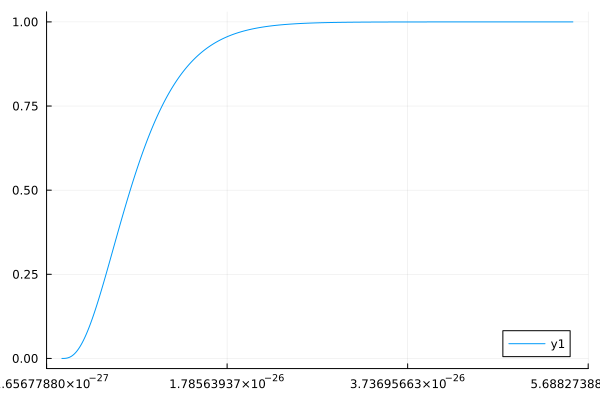

In [157]:
plot(energies, cdf_energies)

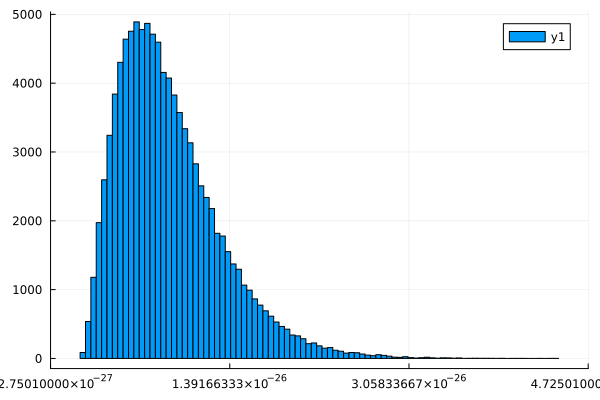

In [158]:
histogram([sampler(energies, cdf_energies) for _ in 1:100000], bins=100)

In [159]:
# Sample from position and velocity distributions for comparison
energy(particle, trap) = U(particle.r, trap) + (1/2) * m * (particle.v ⋅ particle.v)

# Look at energy distribution
particles = StructArray{Particle}(undef, 100000)
r, v, a = make_distributions(T, trap)
initialize_dists_particles!(r, v, a, 1, particles, 1.0, true)

energies_ = zeros(length(particles))
for i in 1:length(particles)
    energies_[i] = energy(particles[i], trap)
end
;

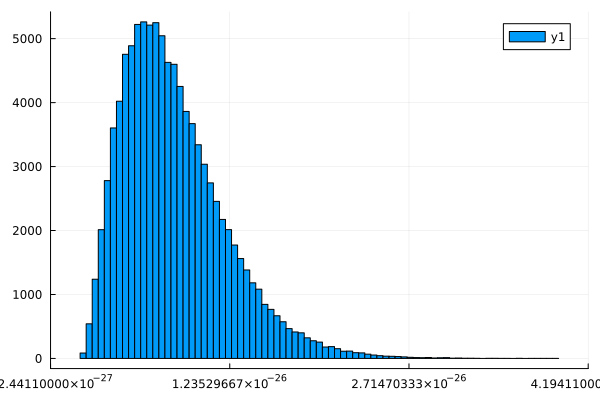

In [160]:
histogram(energies_, bins=100)

In [87]:
shaved_T_depth = @with_unit 0 "μK"
shaved_U_depth = kB * shaved_T_depth

total_time = @with_unit 100 "ms"               # Total time of simulation
shaving_start_time = @with_unit 30 "ms"        # Start of shaving
shaving_end_time = @with_unit 30 + 30 "ms"     # End of shaving
;

In [112]:
n = 300
save_every = 500
delete_every = 50
dt_min = 1e-8
dt_max = 1e-4
abstol = 1e-5
dt = 1e-7
max_steps = Int64(ceil(total_time / dt))
alg = "rkf12"
use_adaptive = false
dt0 = 1e-5
;

In [113]:
discard(r, v) = false
is_detectable(r) = (abs(r[1]) < 10w0x) && (abs(r[2]) < 10w0y) && (abs(r[3]) < 10 * max(zRx, zRy))

function update(particles, p, s, dt)
    p.time_ += dt
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        r = particles.r[i]
        s.detectable[idx] = is_detectable(r)
    end
    return nothing
end

gravity(r) = SVector(0.0, -9.81, 0.0)

function f(idx, r, v, p)
    if p.shaving_start_time < p.time_ < p.shaving_end_time
        U_depth = p.shaved_U_depth
    else
        U_depth = p.trap.U_max
    end
    return F(r, p.trap) * U_depth / m + gravity(r)
end

function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        push!(s.trajectories[idx], particles.r[i])
    end
    return nothing
end
;

In [114]:
detectable = zeros(Bool, n)
time_ = 0.0

particles = StructArray{Particle}(undef, n)
trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]

r, v, a = make_distributions(T, trap)

p = @params (time_, trap, shaved_U_depth, shaving_start_time, shaving_end_time)
s = @params (detectable, trajectories)

@time propagate_particles!(r, v, a, 
    alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
    dt_min, dt_max, abstol, true
)
mean(s.detectable) |> display

  1.547880 seconds (243.84 k allocations: 59.175 MiB, 3.90% gc time, 8.59% compilation time: 98% of which was recompilation)


0.9133333333333333

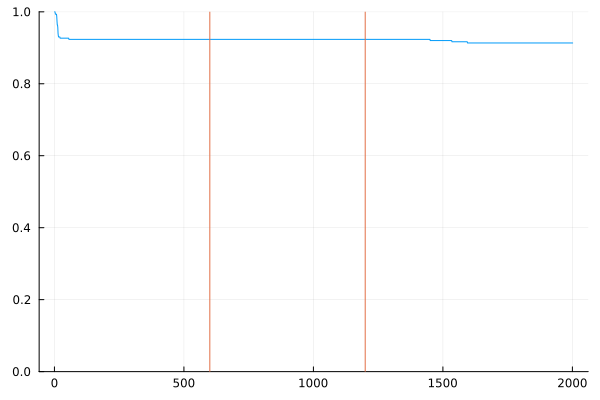

In [115]:
survival = vec(mean(mapreduce(permutedims, vcat, [is_detectable.(s.trajectories[i]) for i ∈ 1:n]), dims=1))
plot(survival, legend=nothing)
plot!(ylim=(0,1))
vline!([shaving_start_time, shaving_end_time] .* 20000)

## Scan in-trap temperature to fit to data

### Data for ODT/lifetime paper

In [51]:
data_xs = [
    0.0600
    0.1000
    0.1600
    0.2000
    0.2500
    0.3200
    0.4000
    0.5000
    0.6000
    0.7800
    1.0000
    1.5200
    2.1000
    2.6500
    3.0000
]
data_ys_ = [
    0.0764
    0.1741
    0.2121
    0.2697
    0.3304
    0.4114
    0.4662
    0.4997
    0.5268
    0.5884
    0.6469
    0.6627
    0.7570
    0.7332
    0.7136
]
data_ys = data_ys_ #./ maximum(data_ys_)

data_ys_errors = [
    0.0164
    0.0215
    0.0340
    0.0208
    0.0225
    0.0262
    0.0307
    0.0309
    0.0226
    0.0401
    0.0377
    0.0485
    0.0422
    0.0382
    0.0343
]
data_ys_errors #./= maximum(data_ys_)
;

### Data from 8/31/22

In [29]:
data_xs = [
         0
    0.0250
    0.0500
    0.0750
    0.1000
    0.1250
    0.1500
    0.1750
    0.2000
    0.2500
    0.3000
    0.3500
    0.4000
    0.4500
    0.5000
    0.7500
    1.0000
] .* 3.5

data_ys_ = [
    0.0122
    0.0927
    0.1415
    0.2067
    0.1880
    0.2272
    0.1935
    0.2051
    0.2348
    0.2562
    0.2513
    0.2443
    0.2310
    0.2738
    0.2374
    0.2902
    0.2626
]
data_ys = data_ys_ #./ maximum(data_ys_)

data_ys_errors = [
    0.0107
    0.0155
    0.0147
    0.0193
    0.0158
    0.0206
    0.0129
    0.0181
    0.0149
    0.0304
    0.0165
    0.0241
    0.0178
    0.0304
    0.0150
    0.0141
    0.0134
]
data_ys_errors #./= maximum(data_ys_)
;

### Data from 10/25/22

In [402]:
data_xs = [
         0
    0.0250
    0.0500
    0.0750
    0.1000
    0.1250
    0.1500
    0.1750
    0.2000
    0.2250
    0.2500
    0.3000
    0.3500
    0.4000
    0.5000
    0.6000
    0.7000
    0.7500
    0.8000
    0.9000
    1.0000
]

data_ys_ = [
    0.0213
    0.1146
    0.3002
    0.3983
    0.4752
    0.5161
    0.5678
    0.6092
    0.6087
    0.6482
    0.6611
    0.7453
    0.7163
    0.7809
    0.7713
    0.7570
    0.7745
    0.8660
    0.7883
    0.8309
    0.7986
]
data_ys = data_ys_ #./ maximum(data_ys_)

data_ys_errors = [
    0.0142
    0.0163
    0.0146
    0.0186
    0.0238
    0.0273
    0.0252
    0.0201
    0.0252
    0.0268
    0.0232
    0.0266
    0.0283
    0.0285
    0.0407
    0.0297
    0.0318
    0.0359
    0.0345
    0.0345
    0.0411
]
data_ys_errors #./= maximum(data_ys_)
;

### Data from 4/3/23 - 780 nm tweezer at 1 V trap depth, trap depth of 2.5 mK

In [134]:
data_xs = [
    0.0169
    0.0385
    0.0667
    0.1026
    0.1436
    0.2034
    0.2462
    0.3077
    0.3641
    1.0000
]
data_ys_ = [
    7.5952
   20.7286
  112.5571
  131.9714
  207.5714
  340.1571
  344.3958
  462.1292
  491.1593
  703.3917
]
data_ys = data_ys_ ./ maximum(data_ys_)
;

## Fit to data

In [137]:
# Create a "shaving" plot for a single temperature
const T = @with_unit 200 "μK"
r, v, a = make_distributions(T, trap)
shaved_U_depth_ratios = data_xs

surviving_fractions = zeros(length(shaved_U_depth_ratios))
for (i, shaved_U_depth_ratio) ∈ enumerate(shaved_U_depth_ratios)
    shaved_U_depth = original_U_depth * shaved_U_depth_ratio

    # Reset parameters for current run
    p.time_ = 0.0
    p.shaved_U_depth = shaved_U_depth

    particles = StructArray{Particle}(undef, n)
    detectable = zeros(Bool, n)
    trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
    s = @params (detectable, trajectories)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
        dt_min, dt_max, abstol, true)

    surviving_fractions[i] = mean(s.detectable)    
end

  1.671945 seconds (2.92 k allocations: 47.274 MiB)
  1.477414 seconds (2.90 k allocations: 47.274 MiB)
  1.428447 seconds (2.91 k allocations: 47.274 MiB)
  1.443044 seconds (2.91 k allocations: 47.274 MiB)
  1.335312 seconds (2.91 k allocations: 47.274 MiB)
  1.395448 seconds (2.92 k allocations: 47.274 MiB)
  1.495633 seconds (2.91 k allocations: 47.274 MiB)
  1.491496 seconds (2.92 k allocations: 47.274 MiB)
  1.600192 seconds (2.92 k allocations: 47.274 MiB)
  1.299244 seconds (2.90 k allocations: 47.273 MiB)


Error: 0.0032302083644695245

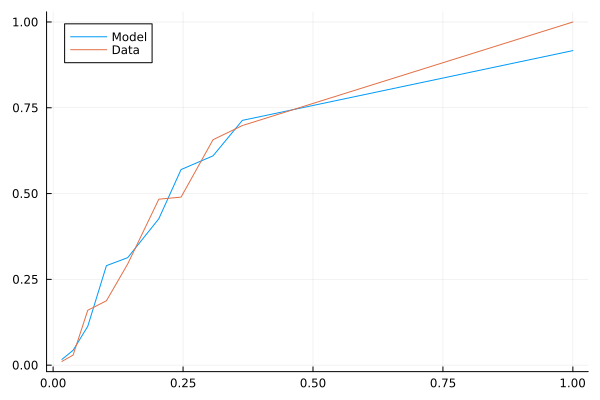

In [138]:
plot()
print("Error: ", mean((surviving_fractions .- data_ys).^2))
plot!(data_xs, surviving_fractions, label="Model")
plot!(data_xs, data_ys, label="Data")

In [123]:
center_T = 34.0
Ts = 1e-6 .* collect((center_T-15):1:(center_T+15))
;

surviving_fractions = zeros(length(Ts), length(shaved_U_depth_ratios))

iter = Ts
for (i, T) ∈ enumerate(Ts)
    display(T)

    r, v, a = make_distributions(T, trap)

    for (j, shaved_U_depth_ratio) ∈ enumerate(shaved_U_depth_ratios)
        shaved_U_depth = original_U_depth * shaved_U_depth_ratio

        # Reset parameters for current run
        p.time_ = 0.0
        p.shaved_U_depth = shaved_U_depth

        particles = StructArray{Particle}(undef, n)
        detectable = zeros(Bool, n)
        trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
        s = @params (detectable, trajectories)

        @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
            dt_min, dt_max, abstol, true)

        surviving_fractions[i,j] = mean(s.detectable)    
    end

end

1.8999999999999998e-5

  1.400612 seconds (2.80 k allocations: 47.265 MiB)
  1.389898 seconds (2.90 k allocations: 47.274 MiB)
  1.350920 seconds (2.91 k allocations: 47.274 MiB)


LoadError: InterruptException:

In [62]:
χ²(data, data_errors, preds) = sum((data .- preds).^2 ./ data_errors.^2);

In [63]:
function model_with_best_scaling(model_ys, data_ys, data_ys_errors)
    min_error = Inf
    best_scaling = 1.0
    for scaling ∈ 0.1:0.01:0.4
        error = χ²(data_ys, data_ys_errors, model_ys .* scaling)
        if error < min_error
            min_error = error
            best_scaling = scaling
        end
    end
    print(best_scaling)
    return model_ys .* best_scaling
end

model_with_best_scaling (generic function with 1 method)

In [64]:
χ²_errors = 1e-12 .* [
    χ²(
        data_ys, 
        data_ys_errors, 
        model_with_best_scaling(surviving_fractions[i,:], data_ys, data_ys_errors)
        ) 
    for i ∈ 1:size(surviving_fractions, 1)]
;

0.230.230.240.240.240.240.240.240.240.240.240.250.250.250.250.250.250.250.250.250.260.260.260.260.260.260.260.260.260.260.27

In [65]:
using LsqFit
@. model(T, p) = p[1] * (T - p[2])^2 + p[3]

model (generic function with 1 method)

3-element Vector{Float64}:
  0.07450837960331883
 33.958426778350436
 30.769671509195046

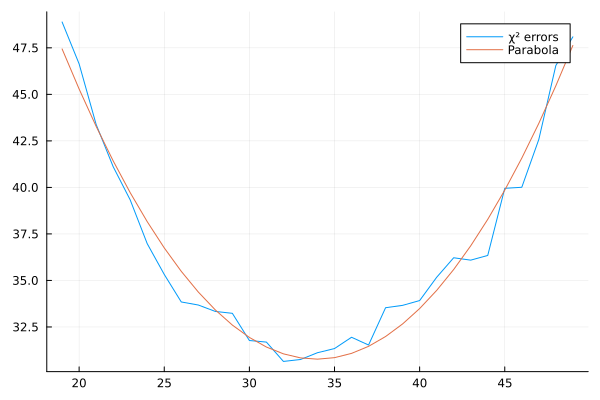

In [137]:
x = 0
y = 0
lb = [0, 10.0, 10]
p0 = [1e2, 31.0, 32]
ub = [1e4, 70.0, 50]
fitted_model = curve_fit(model, Ts[x+1:end-y] .* 1e6, χ²_errors[x+1:end-y] .* 1e12, p0, lower=lb, upper=ub)
display(fitted_model.param)
plot(Ts[x+1:end-y] .* 1e6, χ²_errors[x+1:end-y]  .* 1e12, label="χ² errors")
plot!(Ts[x+1:end-y] .* 1e6, model(Ts[x+1:end-y] .* 1e6, fitted_model.param), label="Parabola")

In [138]:
# The second derivative with respect to T is given by
sqrt(2 * (2 * fitted_model.param[1])^(-1))

3.6635105010515345

3.2e-5

0.25

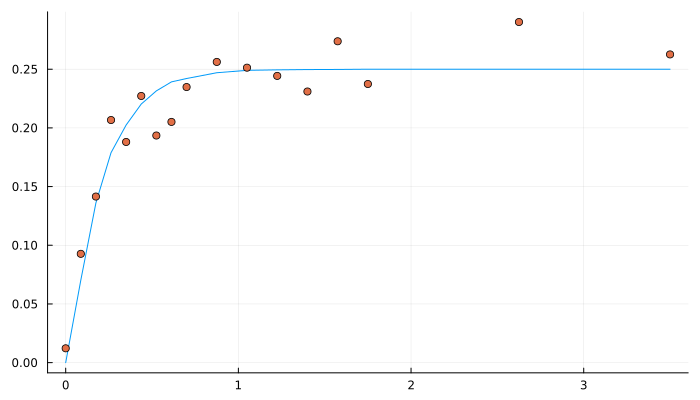

In [68]:
min_error, best_idx = findmin(χ²_errors)
Ts[best_idx] |> display
best_preds = model_with_best_scaling(surviving_fractions[best_idx,:], data_ys, data_ys_errors)

plot(shaved_U_depth_ratios .* 3.5, best_preds, legend=nothing, size=(700,400))
scatter!(data_xs, data_ys)

In [61]:
shaved_U_depth_ratios

17-element Vector{Float64}:
 0.0
 0.025
 0.05
 0.075
 0.1
 0.125
 0.15
 0.175
 0.2
 0.25
 0.3
 0.35
 0.4
 0.45
 0.5
 0.75
 1.0

### Bootstrap model outputs to get an error range

In [206]:
collect(shaved_U_depth_ratios[1]:0.01:shaved_U_depth_ratios[end])

85-element Vector{Float64}:
 0.017142857142857144
 0.027142857142857142
 0.037142857142857144
 0.047142857142857146
 0.05714285714285714
 0.06714285714285714
 0.07714285714285714
 0.08714285714285715
 0.09714285714285714
 0.10714285714285714
 0.11714285714285715
 0.12714285714285714
 0.13714285714285715
 ⋮
 0.7471428571428571
 0.7571428571428571
 0.7671428571428571
 0.7771428571428571
 0.7871428571428571
 0.7971428571428572
 0.8071428571428572
 0.8171428571428572
 0.8271428571428572
 0.8371428571428572
 0.8471428571428572
 0.8571428571428571

In [214]:
n = 2_000
T = 60e-6
r, v, a = make_distributions(T)

simul_xs = collect(shaved_U_depth_ratios[1]:0.01:shaved_U_depth_ratios[end])

detectable_all = zeros(n, length(simul_xs))

for (j, shaved_U_depth_ratio) ∈ enumerate(simul_xs)
    shaved_U_depth = original_U_depth * shaved_U_depth_ratio

    # Reset parameters for current run
    p.time = 0.0
    p.shaved_U_depth = shaved_U_depth

    particles = StructArray{Particle}(undef, n)
    detectable = zeros(Bool, n)
    trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
    s = @params (detectable, trajectories)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
        dt_min, dt_max, abstol, true)

    detectable_all[:,j] .= s.detectable
    
end

  0.841783 seconds (791 allocations: 446.188 KiB)
  0.848623 seconds (798 allocations: 446.547 KiB)
  0.845699 seconds (789 allocations: 446.156 KiB)
  0.829988 seconds (794 allocations: 446.250 KiB)
  0.857730 seconds (796 allocations: 446.312 KiB)
  0.847742 seconds (794 allocations: 446.516 KiB)
  0.844626 seconds (789 allocations: 446.125 KiB)
  0.856549 seconds (796 allocations: 446.312 KiB)
  0.834775 seconds (794 allocations: 446.250 KiB)
  0.845892 seconds (794 allocations: 446.250 KiB)
  0.866340 seconds (798 allocations: 446.375 KiB)
  0.841739 seconds (796 allocations: 446.312 KiB)
  0.846172 seconds (795 allocations: 446.281 KiB)
  0.860793 seconds (794 allocations: 446.250 KiB)
  0.856425 seconds (800 allocations: 446.438 KiB)
  0.853421 seconds (793 allocations: 446.219 KiB)
  0.854698 seconds (792 allocations: 446.219 KiB)
  0.842520 seconds (789 allocations: 446.156 KiB)
  0.861241 seconds (796 allocations: 446.312 KiB)
  0.845081 seconds (794 allocations: 446.250 KiB)


In [215]:
n_bootstraps = 10000

surviving_fractions_lower = zeros(length(simul_xs))
surviving_fractions_upper = zeros(length(simul_xs))

for i ∈ eachindex(simul_xs)
    bootstrap_idxs = rand(1:n, n, n_bootstraps)
    bootstrap_samples = detectable_all[:,i][bootstrap_idxs]
    bootstrap_means = vec(mean(bootstrap_samples, dims=1))
    surviving_fractions_lower[i] = percentile(bootstrap_means, 50 - 34.1)
    surviving_fractions_upper[i] = percentile(bootstrap_means, 50 + 34.1)
end

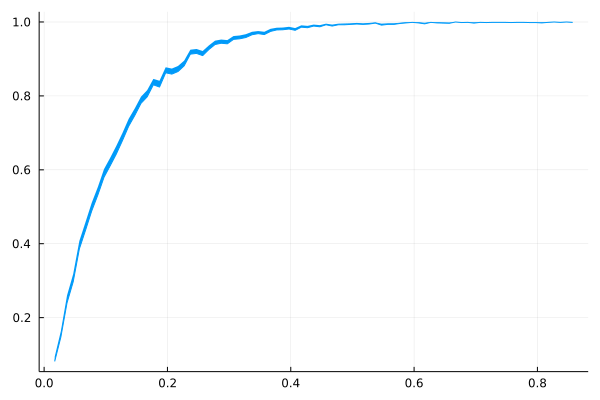

In [218]:
plot(simul_xs, surviving_fractions_lower, fillrange=surviving_fractions_upper, legend=nothing)

In [208]:
simul_vals = vec(mean(detectable_all, dims=1));

In [219]:
simul_vals

15-element Vector{Float64}:
 0.09084
 0.1838
 0.30796
 0.382
 0.4655
 0.56684
 0.65334
 0.74328
 0.81508
 0.89236
 0.94496
 0.98818
 0.99772
 0.99912
 0.99966

### Bootstrapping data

In [68]:
using Distributions

In [69]:
data_sampler(μs, ϵs) = [Normal(μs[i], ϵs[i]) for i ∈ eachindex(μs)]
ds = data_sampler(data_ys, data_ys_errors)
;

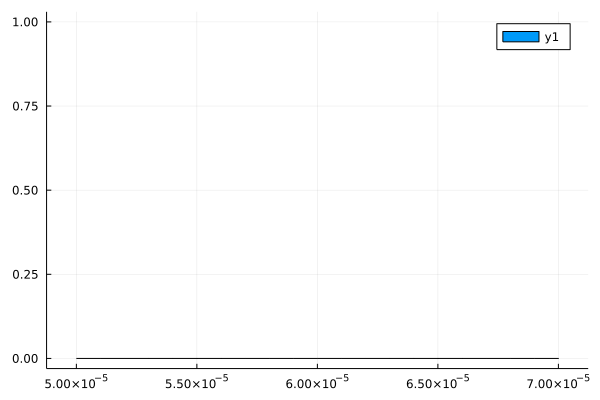

In [70]:
n_bootstraps = 100_000
min_Ts = zeros(n_bootstraps)

for i ∈ 1:n_bootstraps
    bootstrap_sample = rand.(ds)
    squared_errors = vec(sum((bootstrap_sample .- surviving_fractions').^2 ./ length(data_ys), dims=1))
    _, best_idx = findmin(squared_errors)
    min_Ts[i] = Ts[best_idx]
end
histogram(min_Ts, bins=Ts)

In [71]:
mean(min_Ts)

7.000000000000008e-5

In [72]:
percentile(min_Ts, 50 - 34.1) |> display
percentile(min_Ts, 50 + 34.1) |> display

7.0e-5

7.0e-5

┌ Warning: X:\My Drive\github\BeamPropagation.jl\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\Christian\.julia\packages\Revise\3RMhb\src\packagedef.jl:572
